In [434]:
import numba
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

lendo conj. dados

In [435]:
data = pd.read_csv('dataset\\sleeptime_prediction_dataset.csv')
data.head(3)

,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
0,1.12,0.52,3.29,7.89,216.08,0.75,3.45
1,2.85,0.49,4.22,5.03,206.18,0.67,4.88
2,2.20,1.81,4.04,9.23,28.73,0.35,3.61


In [436]:
data.shape

(2000, 7)

## Previsão de tempo de sono
1) Ajuste um modelo linear da forma
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \ldots + a_m x_m,
$$
onde $y$ é o tempo de sono e $x_i$ são as variáveis independentes (colunas do dataset).

Resposta:

$b$=É o valor previsto

$y$=É o valor real

$a$ = $[a_0, a_1, ...., a_n]$ ,É o vetor dos coeficientes do modelo incluindo o interceptor

$M$ = Matriz das carateristicas(features), no qual adciona a coluna do intercepto($a_0$)

$$
b = M\cdot a 
$$

In [437]:
# Resolucao padrão do numpy para essa equação
@numba.jit(nopython=True)
def modeloPadrão(M, b):
    return  np.linalg.inv(np.dot(M.T, M)) @ M.T @ b,

In [438]:
# Matriz de caracteristicas/Independente
X = data.drop(columns=['SleepTime']).values.astype(np.float32)

# Matriz do valor real
y = data['SleepTime'].values.astype(np.float32).reshape(-1, 1)

In [439]:
X[0:5]

array([[  1.12,   0.52,   3.29,   7.89, 216.08,   0.75],
       [  2.85,   0.49,   4.22,   5.03, 206.18,   0.67],
       [  2.2 ,   1.81,   4.04,   9.23,  28.73,   0.35],
       [  1.8 ,   0.5 ,   1.62,   7.68, 276.77,   1.21],
       [  0.47,   0.54,   1.6 ,   4.94, 170.54,   0.95]], dtype=float32)

In [440]:
y[0:5]

array([[3.45],
       [4.88],
       [3.61],
       [4.94],
       [5.5 ]], dtype=float32)

In [441]:
M = np.concatenate((np.ones((X.shape[0],1), dtype=np.float32), X), axis=1)

> Primeira coluna é do inteceptor

In [442]:
b = y

In [443]:
(M.T@M).shape, b.shape

((7, 7), (2000, 1))

In [444]:
coef_ = modeloPadrão(M, b)

2) Escreva o sistema linear $M a = b$ associado aos mínimos quadrados que representa o modelo ajustado (lembre-se que as variáveis do problema de ajuste são os coeficientes $a_i$ e os dados são os valores de $x_i$ e $y$).


* O objetivo é encontrar $\alpha$ que minimiza o erro onde:
$$
E = ||b - M\cdot a||^2 =  (b - Ma)^T (b-Ma) = b^Tb - 2a^TX^Ty + a^T M^T Ma$$

* Deriva em relação a $a$:
$$
\frac{∂E}{∂a} = -2M^Tb + 2M^TMa = 0
$$

* Resolve 
$$M^TMa =M^Tb $$

Observação: $A=M^TM$ o $b = M^Tb$

**Usando decomposição QR:**

1. $X^T X b = X^T y$
2. $(QR)^T (QR) b = (QR)^T y$
3. $R^T (Q^T Q) R b = R^T Q^T y$
4. $R^T R b = R^T Q^T y$
5. $(R^T)^{-1} R^T R b = (R^T)^{-1} R^T Q^T y$
5. $R b = Q^T y$
   * $\alpha = Q^T y$ 
6.  $R b = \alpha$

In [445]:
def decomposicaoQR(A):
    row, col = A.shape

    if col > row:
        return 0
    
    # Inicializando as matrizes Q e R
    Q = np.zeros(shape=(row, col), dtype=np.float32)
    R = np.zeros(shape=(col, col), dtype=np.float32)

    u = 0
    for i in range(col):
        u = A[:, i]
        for j in range(i):
            R[j, i] = np.dot(Q[:, j], A[:, i])
            u -= np.multiply(R[j, i] , Q[:, j])

        R[i, i] = np.linalg.norm(u)
        
        if R[i, i] == 0: return 0

        Q[:, i] = np.divide(u , R[i, i])
    return Q, R

def regressaoQR(M, b):
    M_ = M.copy()
    Q, R = decomposicaoQR(M_)

    alpha = np.dot(Q.T, b)
    return np.linalg.solve(R, alpha)

In [446]:
coefQR_ = regressaoQR(M, b)

In [447]:
div = np.around(coefQR_, 4) - np.around(coef_, 4) 
div

array([[[ 0.000000e+00],
        [ 0.000000e+00],
        [ 0.000000e+00],
        [ 0.000000e+00],
        [ 0.000000e+00],
        [ 0.000000e+00],
        [-9.998679e-05]]], dtype=float32)

In [448]:
(np.power((np.around(coefQR_, 4) - np.around(coef_, 4) ),2).sum())/len(coefQR_)

1.428194070943586e-09

3) Separe seus dados em 80% para treinamento e 20% para teste. Resolva o sistema linear utilizando dois métodos de sua escolha e apenas os dados de treinamento.

In [449]:
# Essa função divide dados de train e test
def train_test(X , y, trainSize=0.80, randomState=42):
    N, _ = X.shape
    # Indeces
    index = np.arange(0, N)

    # definindo o tamanho de instancias do dados de train
    sizeTrain = int(N*0.80)

    # Seleciona indices aleatorios 
    trainIndex = np.random.choice(index, size=sizeTrain)

    # Pega as instancias de treinamento
    train = (
        X[trainIndex, :],
        y[trainIndex, :]
    )

    # Pega os indices de teste
    testIndex = np.setdiff1d(index, trainIndex, assume_unique=True)

    #  ====> Verifica os valores que não estão contido em ambos array
    test = (
        X[testIndex, :],
        y[testIndex, :]
    )
    return train[0], train[1], test[0], test[1] 

In [450]:
xtrain, ytrain, xtest, ytest = train_test(M, b, trainSize=0.8, randomState=1)

In [451]:
def predict(x, coef):
    return np.ravel(np.dot(x, coef))

In [452]:
# Parametros do modelo QR
coefQR_ = regressaoQR(xtrain, ytrain)

# Parametros do modelo Padrão
coefPadrao_ = modeloPadrão(xtrain, ytrain)

4. Calcule o erro resíduo no conjunto de treinamento e no conjunto de teste.

In [453]:
# Predição dos modelos com os dados de treinamento
predQrTrain     = predict(xtrain, coefQR_)
predPadraoTrain = predict(xtrain, coefPadrao_)


# Predição dos modelos com os dados de teste
predQrTest     = predict(xtest, coefQR_)
predPadraoTest = predict(xtest, coefPadrao_)

In [454]:
residuosPadraoTest = ytest.ravel() - predPadraoTest
residuosQRTest = ytest.ravel() - predQrTest

residuosPadraoTrain = ytrain.ravel() - predPadraoTrain
residuosQRTrain = ytrain.ravel() - predQrTrain

5) Compare os resultados dos dois métodos.

In [455]:
from sklearn.metrics import mean_squared_error, r2_score

In [456]:
print(f'''
__________________________________________________________________________________
Conjunto dados de teste
    MSE método QR......: {mean_squared_error(ytest, predQrTest)}
    R2 Score método QR.: {r2_score(ytest, predQrTest)}

    MSE método Padrão......: {mean_squared_error(ytest, predPadraoTest.ravel())}
    R2 Score método Padrão.: {r2_score(ytest, predPadraoTest.ravel())}
___________________________________________________________________________________
Conjunto de dados de treinamento
    MSE método QR......: {mean_squared_error(ytrain, predQrTrain)}
    R2 Score método QR.: {r2_score(ytrain, predQrTrain)}

    MSE método Padrão......: {mean_squared_error(ytrain, predPadraoTrain.ravel())}
    R2 Score método Padrão.: {r2_score(ytrain, predPadraoTrain.ravel())}
''')


__________________________________________________________________________________
Conjunto dados de teste
    MSE método QR......: 2.5018980503082275
    R2 Score método QR.: 0.31159836053848267

    MSE método Padrão......: 2.5019009113311768
    R2 Score método Padrão.: 0.3115975856781006
___________________________________________________________________________________
Conjunto de dados de treinamento
    MSE método QR......: 3.4991204738616943
    R2 Score método QR.: 0.23563051223754883

    MSE método Padrão......: 3.4991204738616943
    R2 Score método Padrão.: 0.23563051223754883



6) Faça um histograma dos resíduos no conjunto de treinamento e no conjunto de teste.

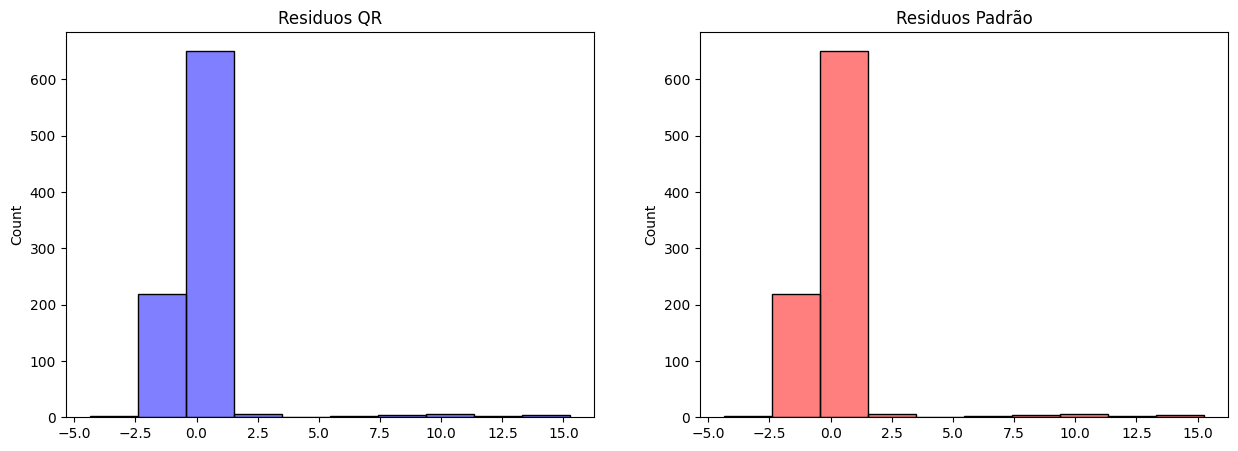

In [465]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sea.histplot(residuosQRTest, bins=10, color='blue', alpha=0.5, ax=ax[0])
ax[0].set_title('Residuos QR')

sea.histplot(residuosPadraoTest.ravel(), bins=10, color='red', alpha=0.5, ax=ax[1])
ax[1].set_title('Residuos Padrão')
plt.show()

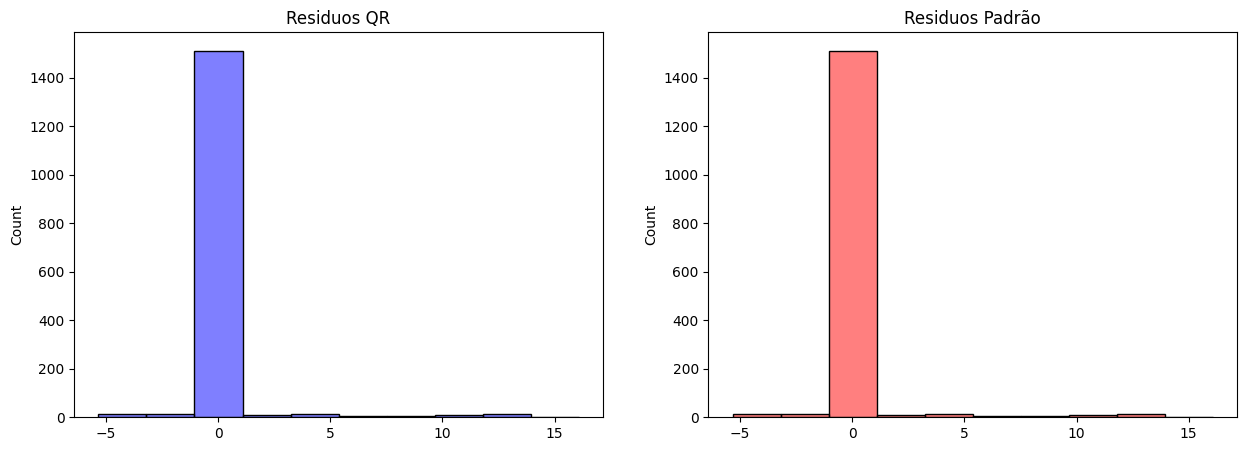

In [466]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sea.histplot(residuosQRTrain, bins=10, color='blue', alpha=0.5, ax=ax[0])
ax[0].set_title('Residuos QR')

sea.histplot(residuosPadraoTrain, bins=10, color='red', alpha=0.5, ax=ax[1])
ax[1].set_title('Residuos Padrão')
plt.show()

7) Ajuste um modelo do tipo polinomial de grau 2 para prever o tempo de sono.

In [507]:
from sklearn.preprocessing import PolynomialFeatures

In [497]:
subdata = data.apply(lambda x: x if np.all(x == data['SleepTime']) else np.power(x, 2))
subdata.head(2)

,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
0,1.2544,0.2704,10.8241,62.2521,46690.5664,0.5625,3.45
1,8.1225,0.2401,17.8084,25.3009,42510.1924,0.4489,4.88


In [510]:
data.corr()

,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
WorkoutTime,1.000000,0.003660,0.032513,0.037904,-0.052671,0.007783,0.188368
ReadingTime,0.003660,1.000000,0.015178,-0.025202,-0.000996,0.026728,0.067199
PhoneTime,0.032513,0.015178,1.000000,0.016314,0.012838,-0.041576,-0.322506
WorkHours,0.037904,-0.025202,0.016314,1.000000,-0.004101,0.044206,-0.298469
CaffeineIntake,-0.052671,-0.000996,0.012838,-0.004101,1.000000,-0.041895,-0.076992
RelaxationTime,0.007783,0.026728,-0.041576,0.044206,-0.041895,1.000000,0.144243
SleepTime,0.188368,0.067199,-0.322506,-0.298469,-0.076992,0.144243,1.000000


In [516]:
x = PolynomialFeatures(degree=4, include_bias=False).fit_transform(X)
x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)

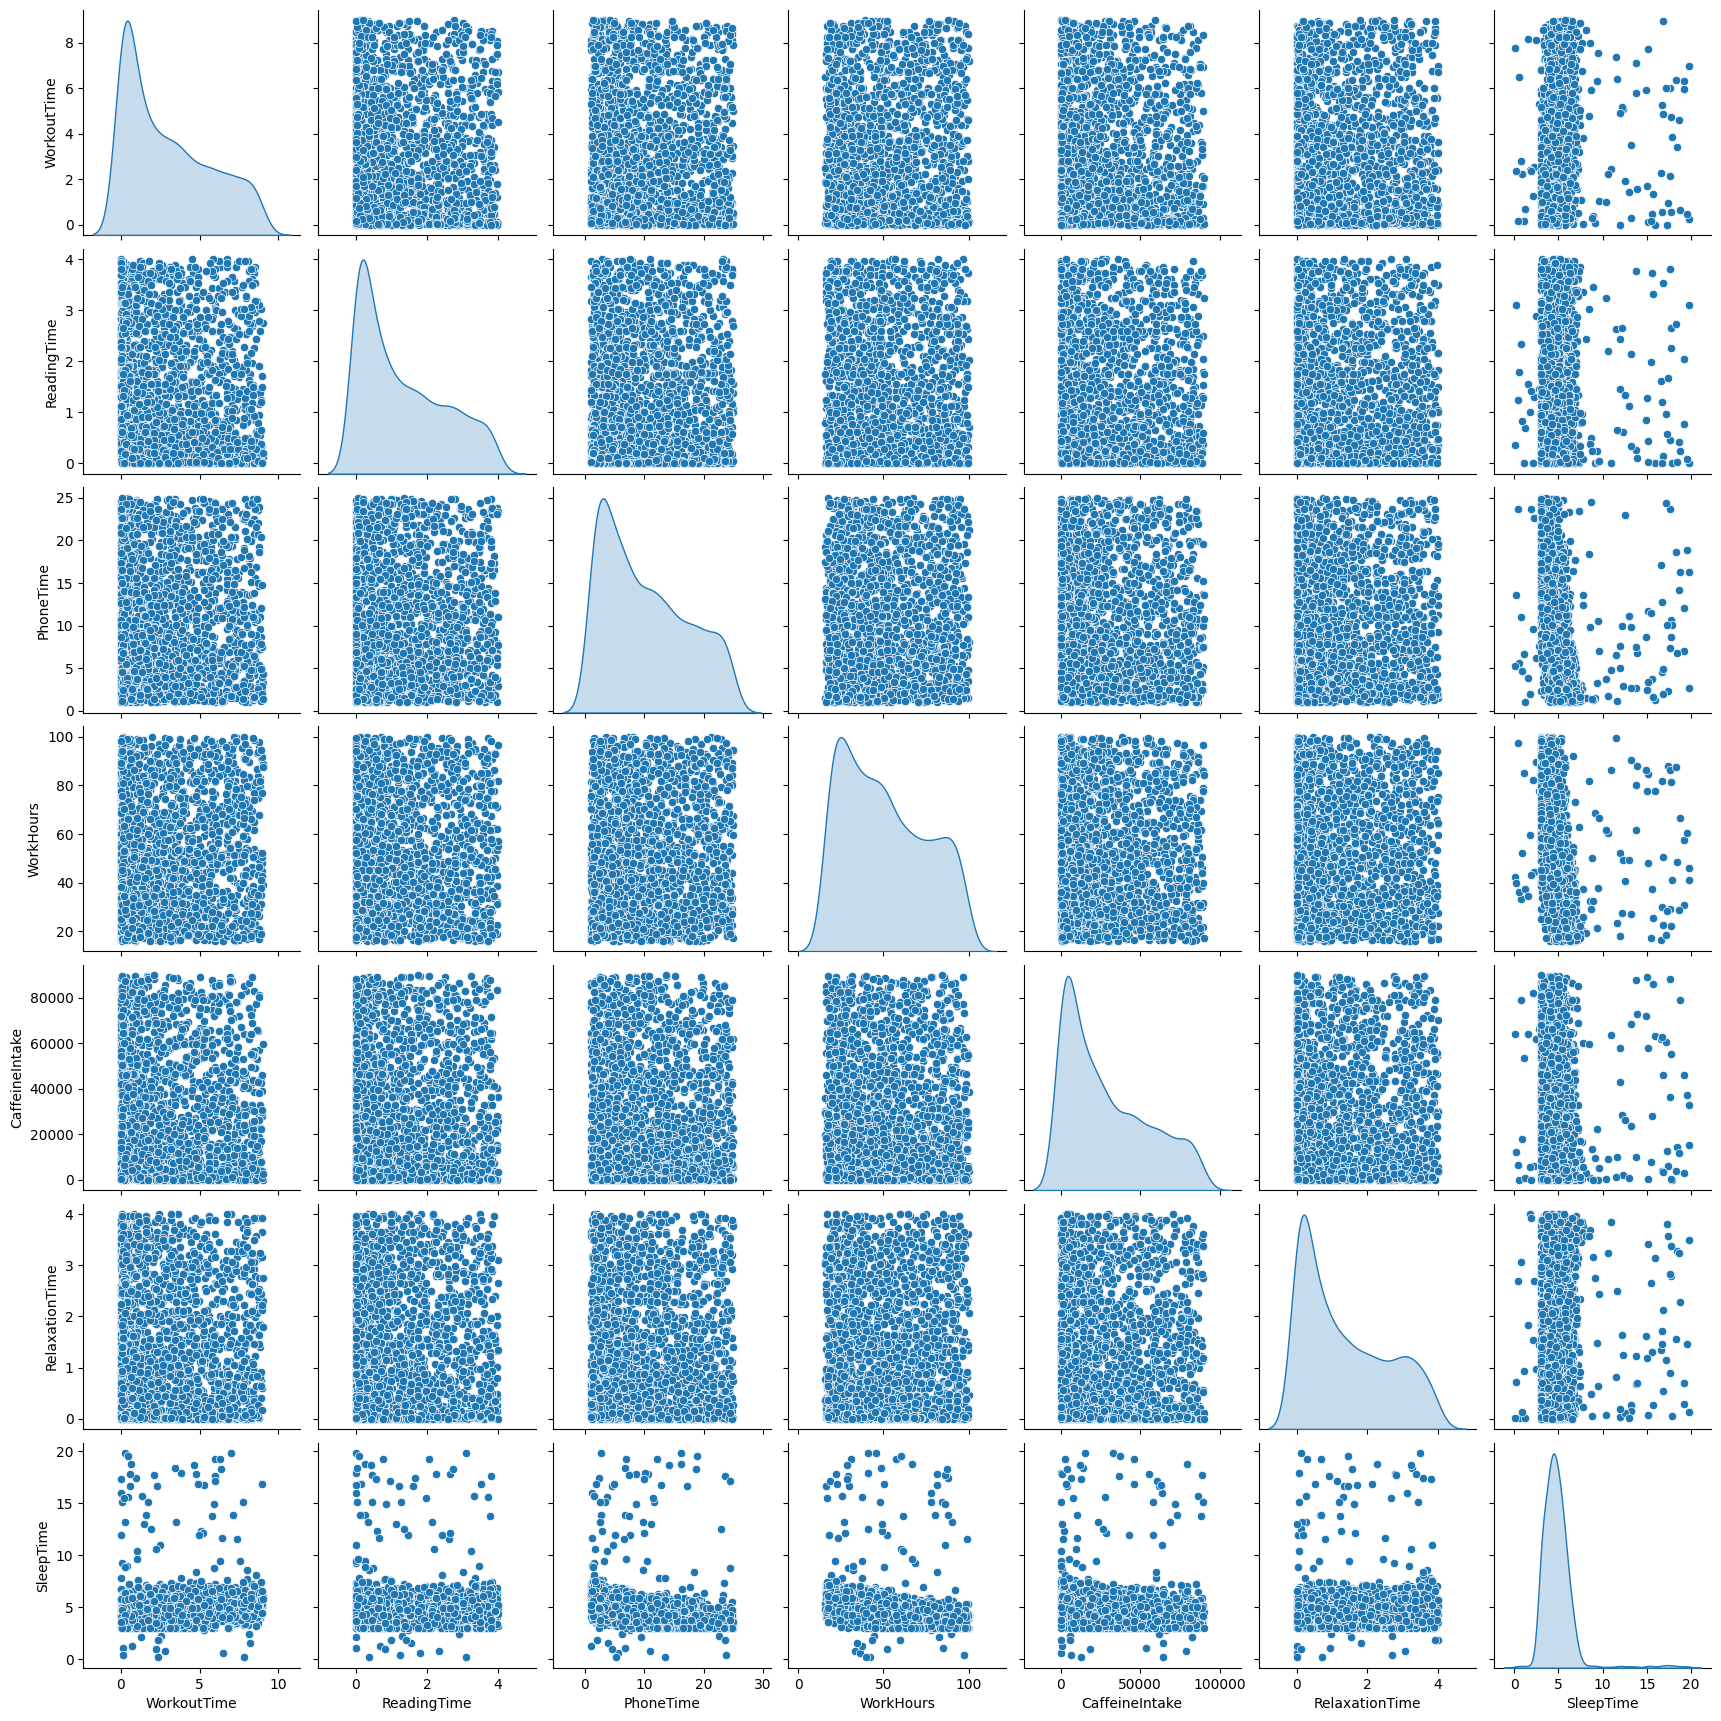

In [495]:
sea.pairplot(subdata, diag_kind='kde')

In [522]:
xtrain, ytrain, xtest, ytest = train_test(x, b, trainSize=0.8, randomState=1)

In [523]:
coefQR_ = regressaoQR(xtrain, ytrain)
#coefPadrao_ = modeloPadrão(xtrain, ytrain)

In [524]:
plt.plt(coef_)

(array([[ 7.8462124e+00],
        [ 4.7676092e-01],
        [ 2.1016255e-01],
        [-5.6123924e-01],
        [-3.6008793e-01],
        [-1.3764079e-03],
        [ 4.8374999e-01]], dtype=float32),)

8. Compare os resultados do modelo polinomial com o modelo linear.

9. Faça 5 slides para apresentar o seu trabalho.